## Ontix Consistency With Old Framework

In [1]:
import pandas as pd

# Download from https://github.com/jan-forest/autoencodix/blob/main/Tutorials/genes_chromosomes.txt
df_genes = pd.read_csv("genes_chromosomes.txt", sep="\t")
df_genes.head()
df_genes = df_genes.loc[
    df_genes["Chromosome/scaffold name"].str.len() < 3
]  ## get rid of scaffolds and keep only chromosomes
df_genes.loc[df_genes["Chromosome/scaffold name"] == "MT", "Karyotype band"] = (
    "MT"  ## create missing karyotype for mito genes
)
print("This will be our chromosomes and latent dimensions in Ontix:")
print(df_genes["Chromosome/scaffold name"].unique())
# Combine Chromosome name and cytoband
df_genes = df_genes.copy()
df_genes.loc[:, "Chr_and_karyotype"] = df_genes.loc[
    :, ["Chromosome/scaffold name", "Karyotype band"]
].apply(lambda x: ":".join(x.values.tolist()), axis=1)
print("This will be our hidden layer in the sparse decoder:")
print(df_genes["Chr_and_karyotype"].unique()[0:20])
print(f"Hidden layer dim: {len(df_genes['Chr_and_karyotype'].unique())}")

This will be our chromosomes and latent dimensions in Ontix:
['MT' 'Y' '21' '13' '18' '22' '20' 'X' '15' '14' '10' '9' '8' '16' '4' '5'
 '7' '6' '19' '12' '11' '3' '17' '2' '1']
This will be our hidden layer in the sparse decoder:
['MT:MT' 'Y:p11.2' 'Y:q11.223' 'Y:q11.221' 'Y:q11.222' 'Y:q11.23'
 'Y:p11.31' 'Y:p11.32' 'Y:q12' '21:p12' '21:q21.1' '21:q21.2' '21:p11.2'
 '13:q12.12' '21:q21.3' '21:q22.11' '13:q12.3' '13:q14.12' '13:q14.2'
 '21:q22.12']
Hidden layer dim: 817


In [2]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")
# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"
ont_genelevel = "chromosome_ont_genelevel_ncbi.txt"
ont_hiddenlevel = "chromosome_ont_hiddenlevel.txt"

# FEATURE TO TO ONTOLOGY LEVEL
df_genes[
    [
        "NCBI gene (formerly Entrezgene) ID",
        "Chr_and_karyotype",
    ]  # Level Feature: Feature (gene) to hidden layer (cytoband)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_genelevel),
    sep="\t",
    header=False,
    index=False,
)

# ONTOLOGY TO LATENT DIMENSION LEVEL
df_genes[
    [
        "Chr_and_karyotype",
        "Chromosome/scaffold name",
    ]  # Level Hidden: hidden layer (cytoband) to latent dimension (chromosome)
].drop_duplicates(  # Chromosomal ontology must be unique
).to_csv(
    os.path.join(data_root, ont_hiddenlevel),
    sep="\t",
    header=False,
    index=False,
)

Changed to: /Users/maximilianjoas/development/autoencodix_package


In [20]:
import os
import autoencodix as acx
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase
from autoencodix.configs import OntixConfig

# ---------------------------------------------------------------------
# Paths
# ---------------------------------------------------------------------
data_root = "data/raw"
rna_file = "combined_rnaseq_formatted.parquet"
meth_file = "combined_meth_formatted.parquet"
clin_file = "combined_clin_formatted.parquet"

# ---------------------------------------------------------------------
# Define individual data modalities
# ---------------------------------------------------------------------
rna_info = DataInfo(
    file_path=os.path.join(data_root, rna_file),
    data_type="NUMERIC",
    filtering="VAR",
)

meth_info = DataInfo(
    file_path=os.path.join(data_root, meth_file),
    data_type="NUMERIC",
    filtering="VAR",
)

anno_info = DataInfo(
    file_path=os.path.join(data_root, clin_file),
    data_type="ANNOTATION",
)

# ---------------------------------------------------------------------
# Combine into DataConfig
# ---------------------------------------------------------------------
data_config = DataConfig(
    data_info={
        "RNA": rna_info,
        "METH": meth_info,
        "ANNO": anno_info,
    },
    annotation_columns=[
        "CANCER_TYPE",
        "CANCER_TYPE_ACRONYM",
        "TMB_NONSYNONYMOUS",
        "AGE",
        "OS_STATUS",
        "GRADE",
        "SEX",
    ],
)

# ---------------------------------------------------------------------
# Define the full DefaultConfig (roughly equivalent to old cfg)
# ---------------------------------------------------------------------
ontix_config = OntixConfig(
    data_config=data_config,
    reproducible=True,
    global_seed=42,
    epochs=500,
    learning_rate=0.0005,
    batch_size=128,
    drop_p=0.3,
    k_filter=1000,
    latent_dim=6,
    reconstruction_loss="bce",
    default_vae_loss="kl",
    beta=0.001,
    save_memory=False,
    scaling="MINMAX",
    device="auto",
    train_ratio=0.7,
    test_ratio=0.2,
    valid_ratio=0.1,
)

# ---------------------------------------------------------------------
# Now pass into your Ontix object
# ---------------------------------------------------------------------

ont_files = [ont_hiddenlevel, ont_genelevel]
ont_files = [os.path.join(data_root, f) for f in ont_files]
ontix = acx.Ontix(
    ontologies=ont_files,
    config=ontix_config,
)


In [21]:
result = ontix.run()

reading parquet: data/raw/combined_rnaseq_formatted.parquet
reading parquet: data/raw/combined_meth_formatted.parquet
reading parquet: data/raw/combined_clin_formatted.parquet
anno key: paired
Features in feature_order not found in all_feature_names: ['100133144', '10357', '10431', '155060', '390284', '57714', '645851', '653553', '729884', '246182', '119385', '653268', '728404', '200810', '138649', '441425', '728747', '729171', '23520', '303', '304', '305', '244', '375719', '441432', '503640', '641522', '432369', '92270', '6791', '85319', '606', '23629', '286076', '414235', '170393', '255352', '283422', '283416', '374467', '84837', '400223', '650662', '280655', '283651', '80035', '283687', '196968', '284185', '147429', '147525', '494514', '574036', '284573', '149469', '84791', '253868', '284836', '54094', '54067', '282566', '114041', '114043', '149992', '55267', '29798', '348738', '339942', '93556', '646450', '317648', '92070', '79614', '153571', '116349', '441108', '285679', '85411', 

Creating plots ...


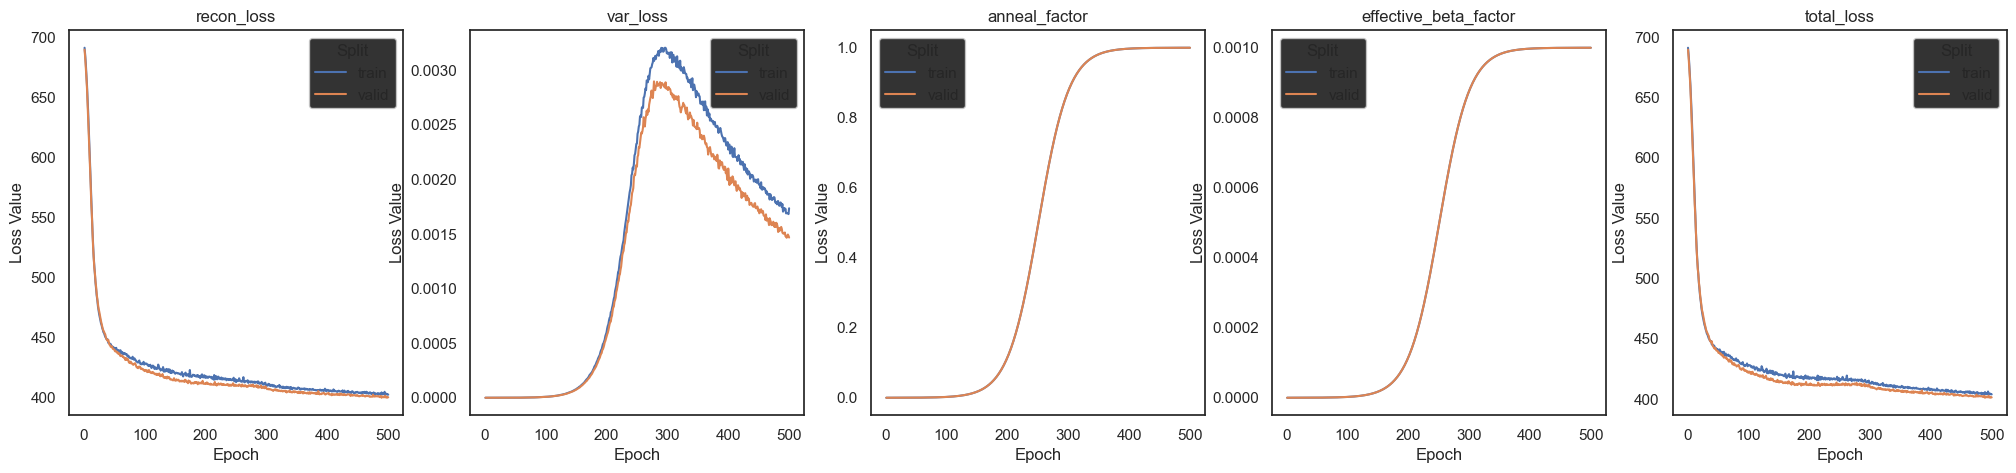

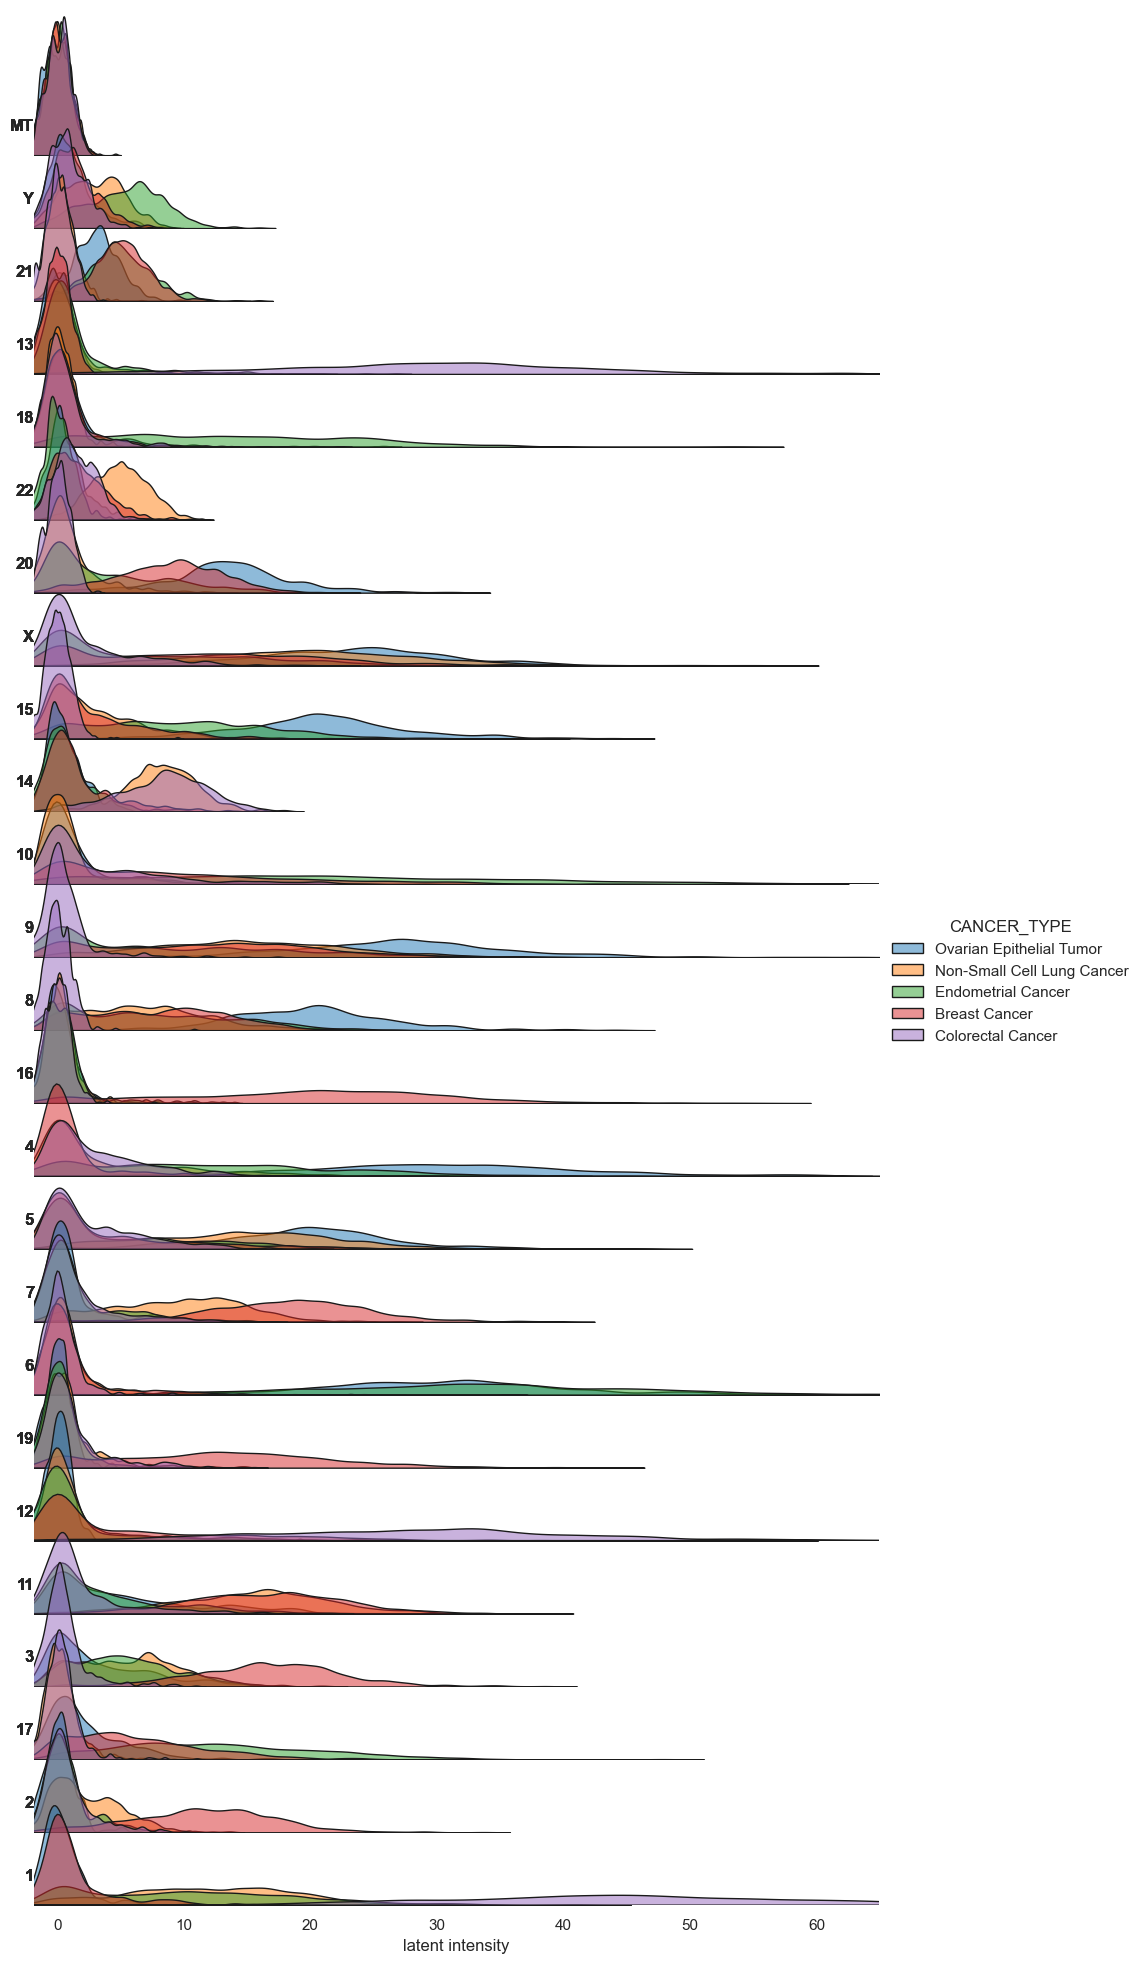

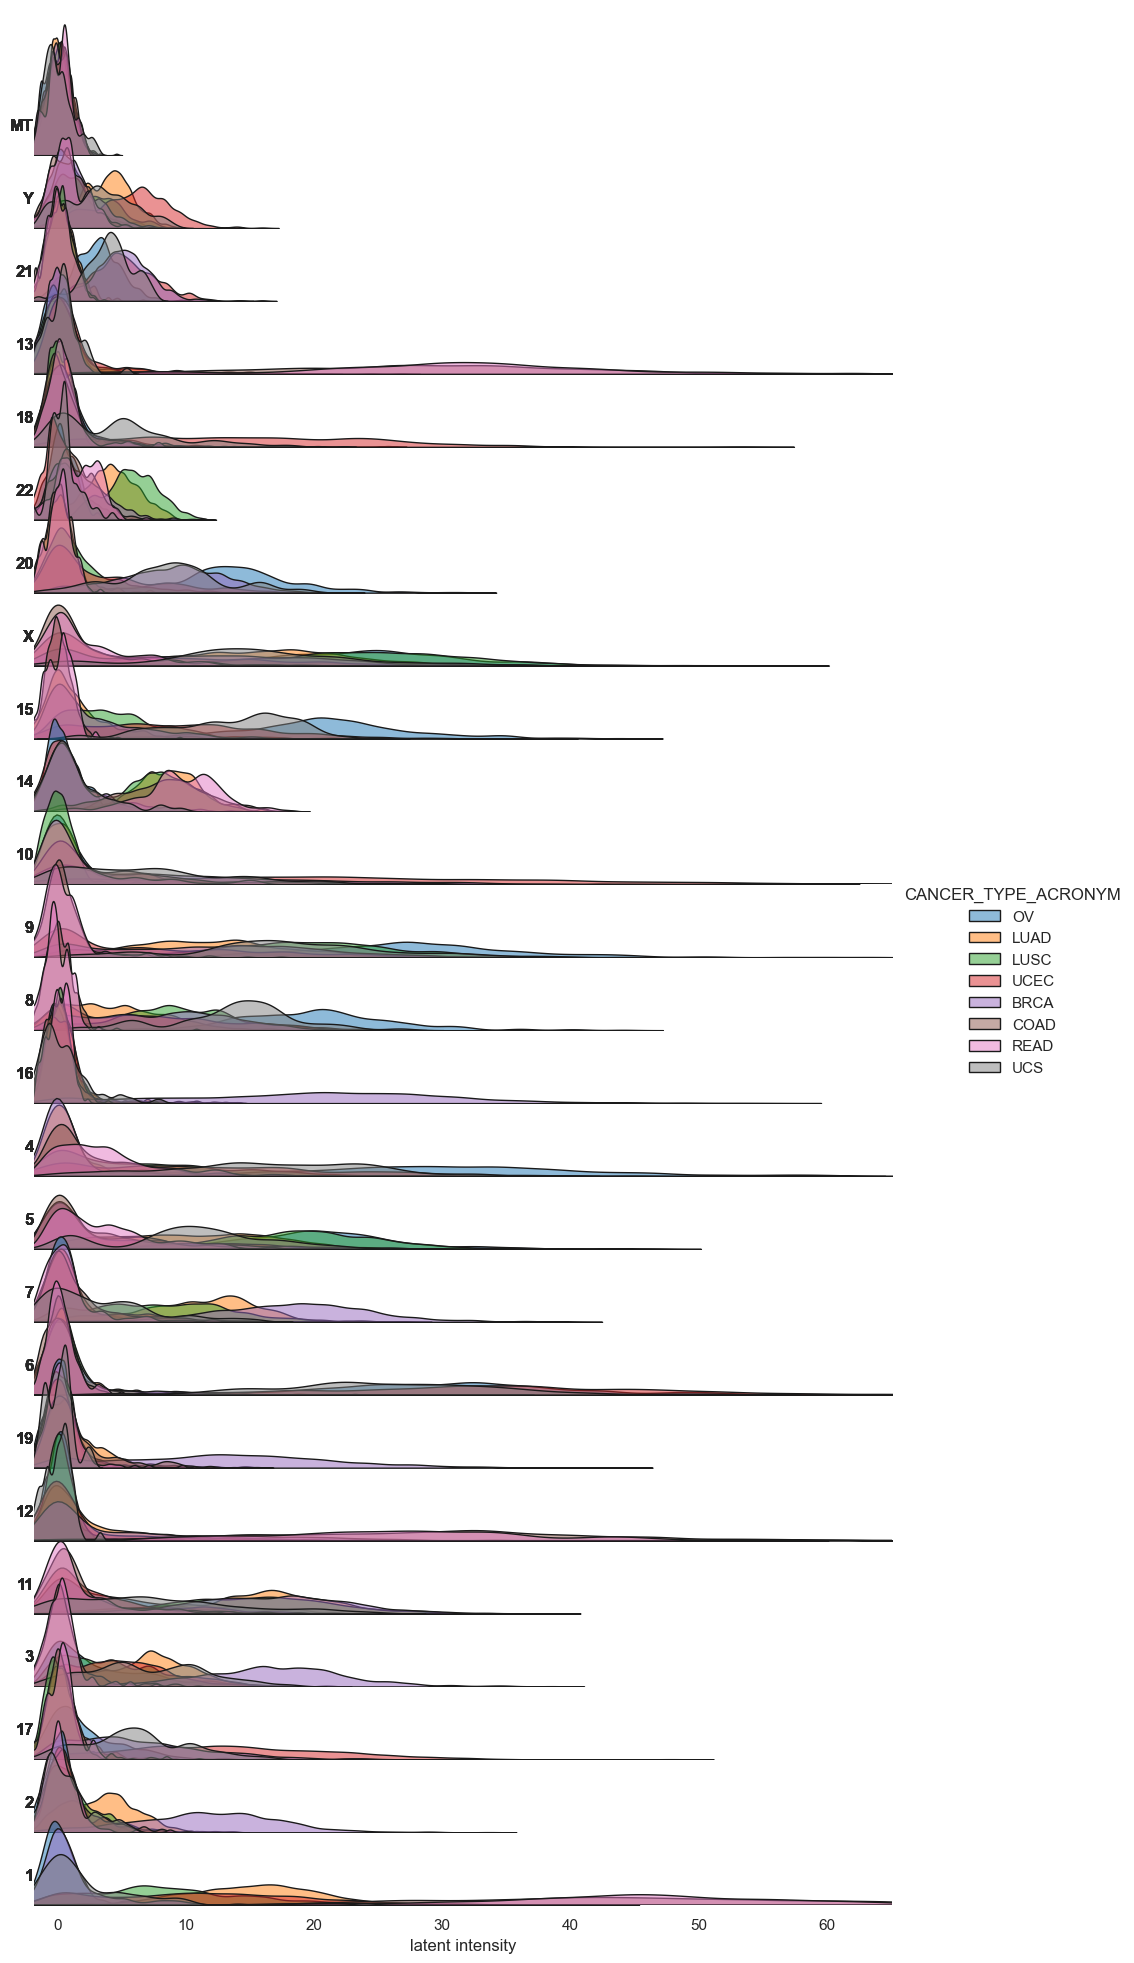

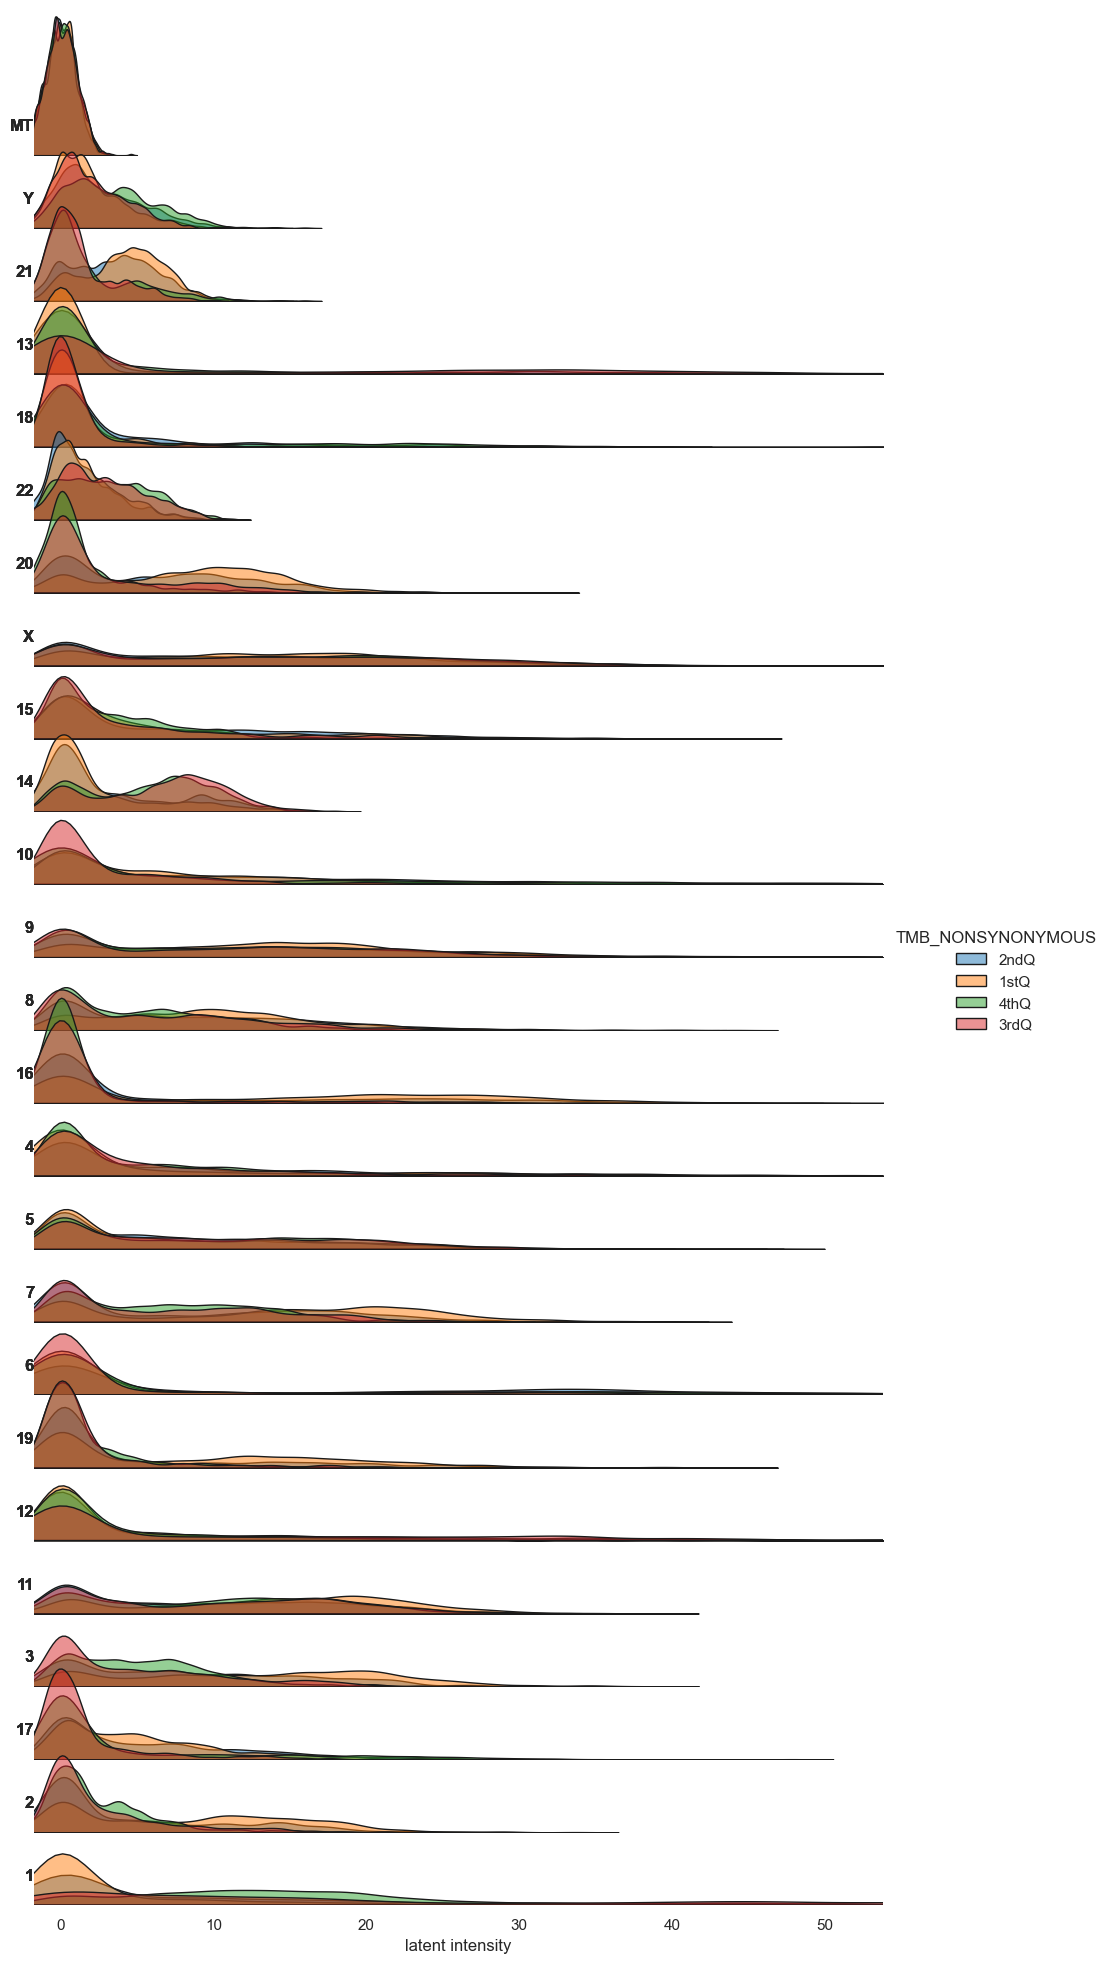

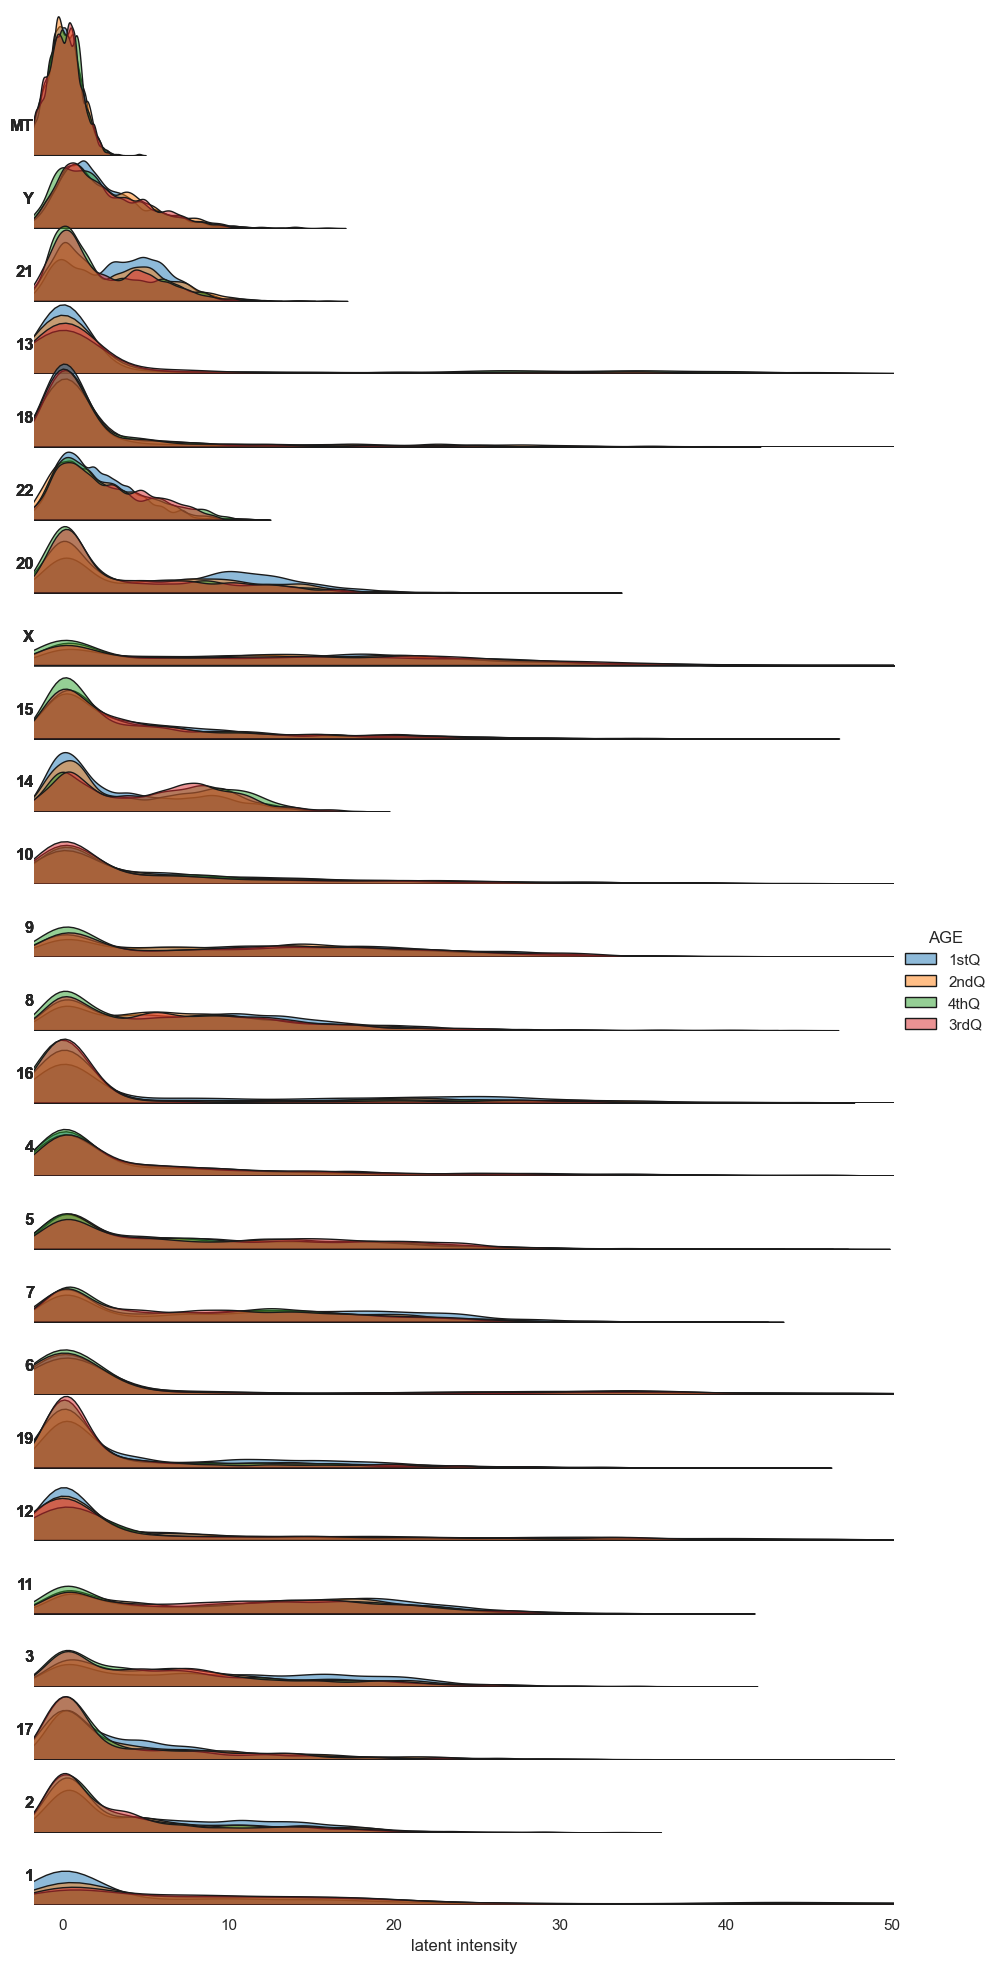

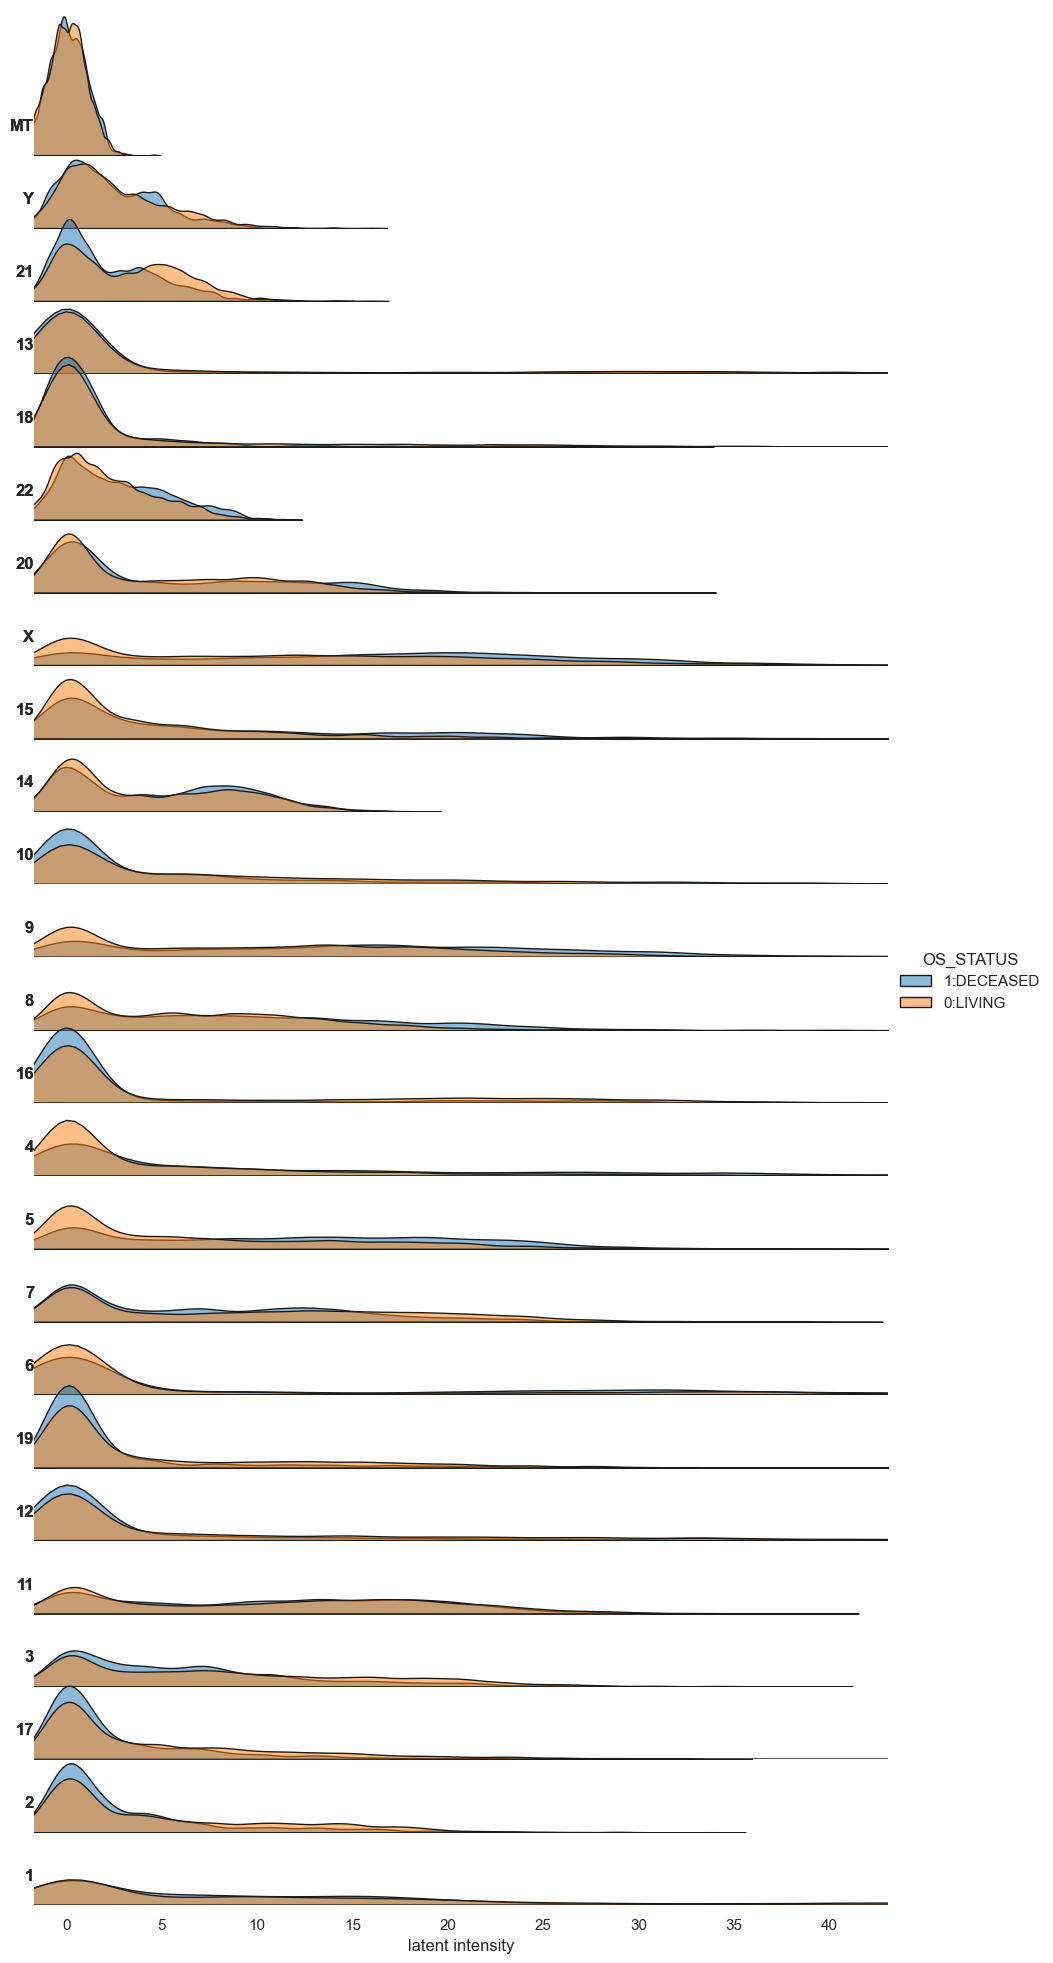

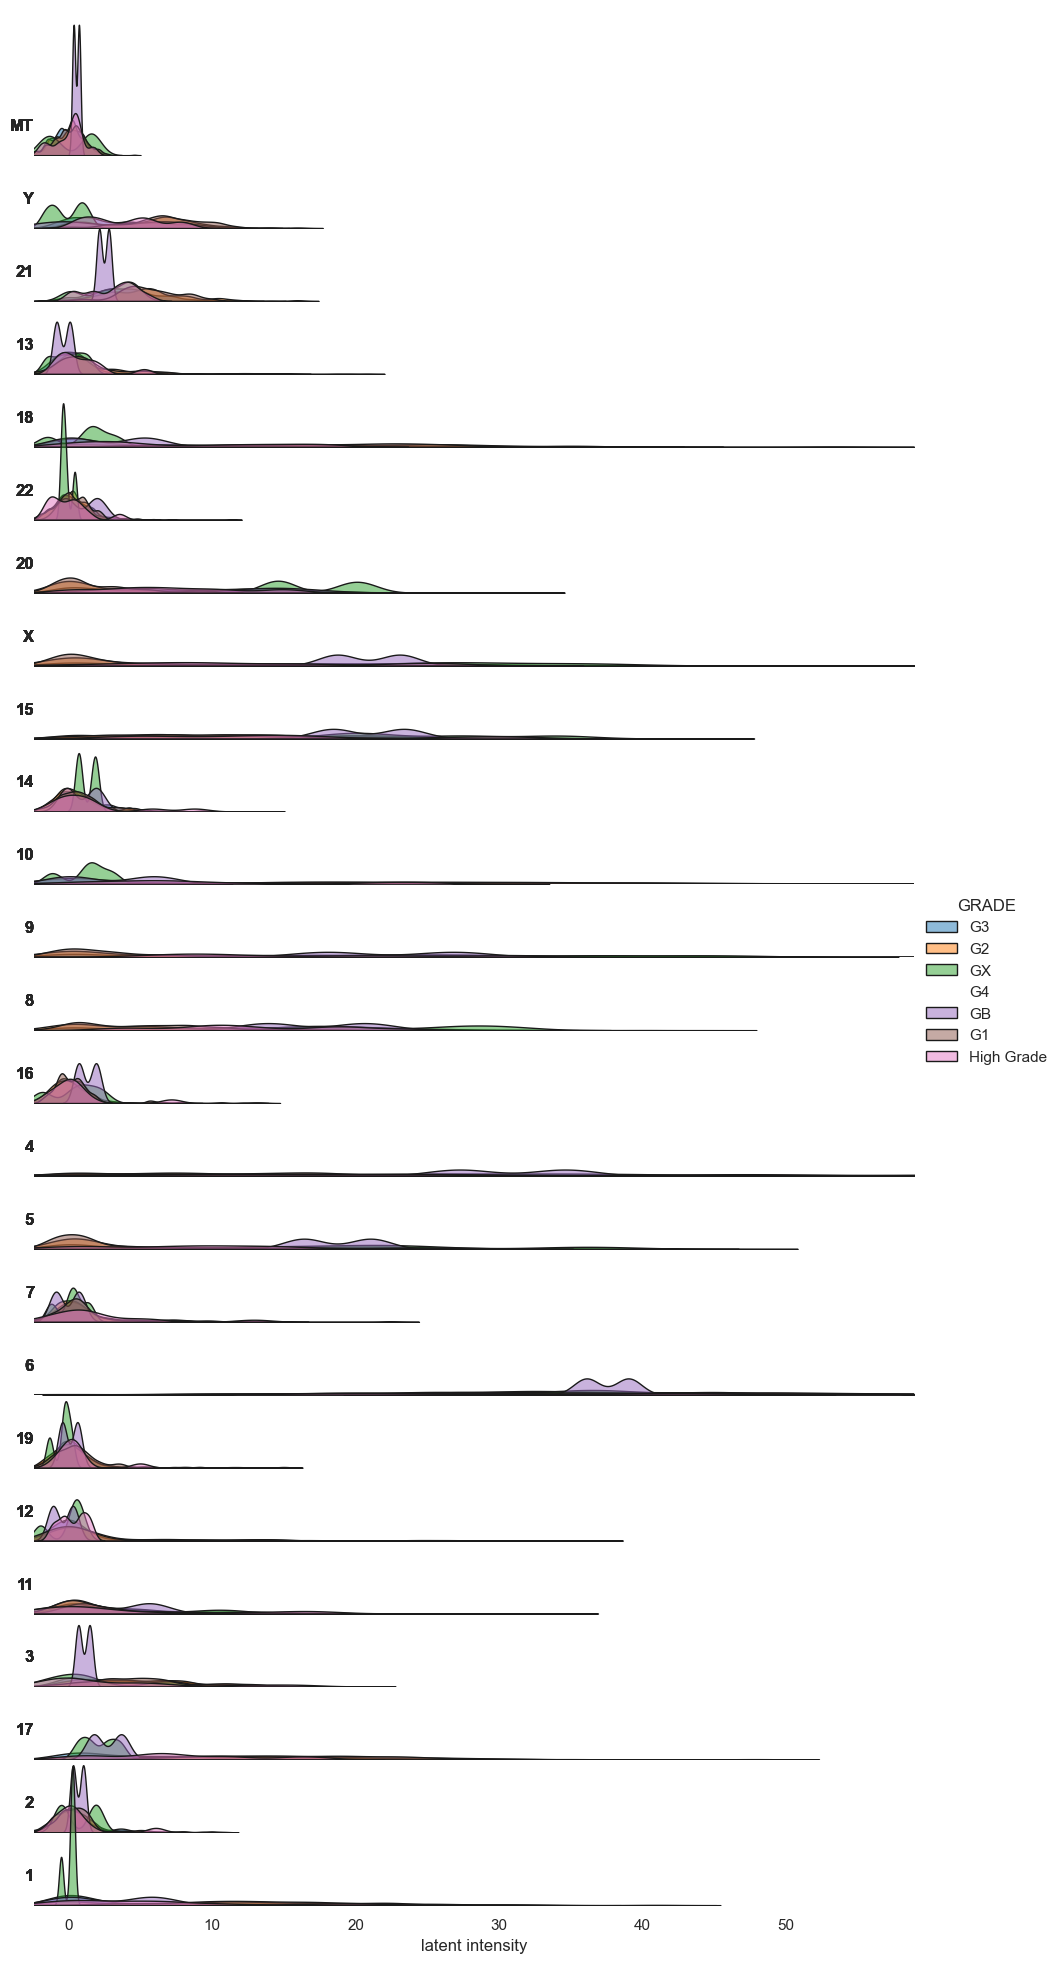

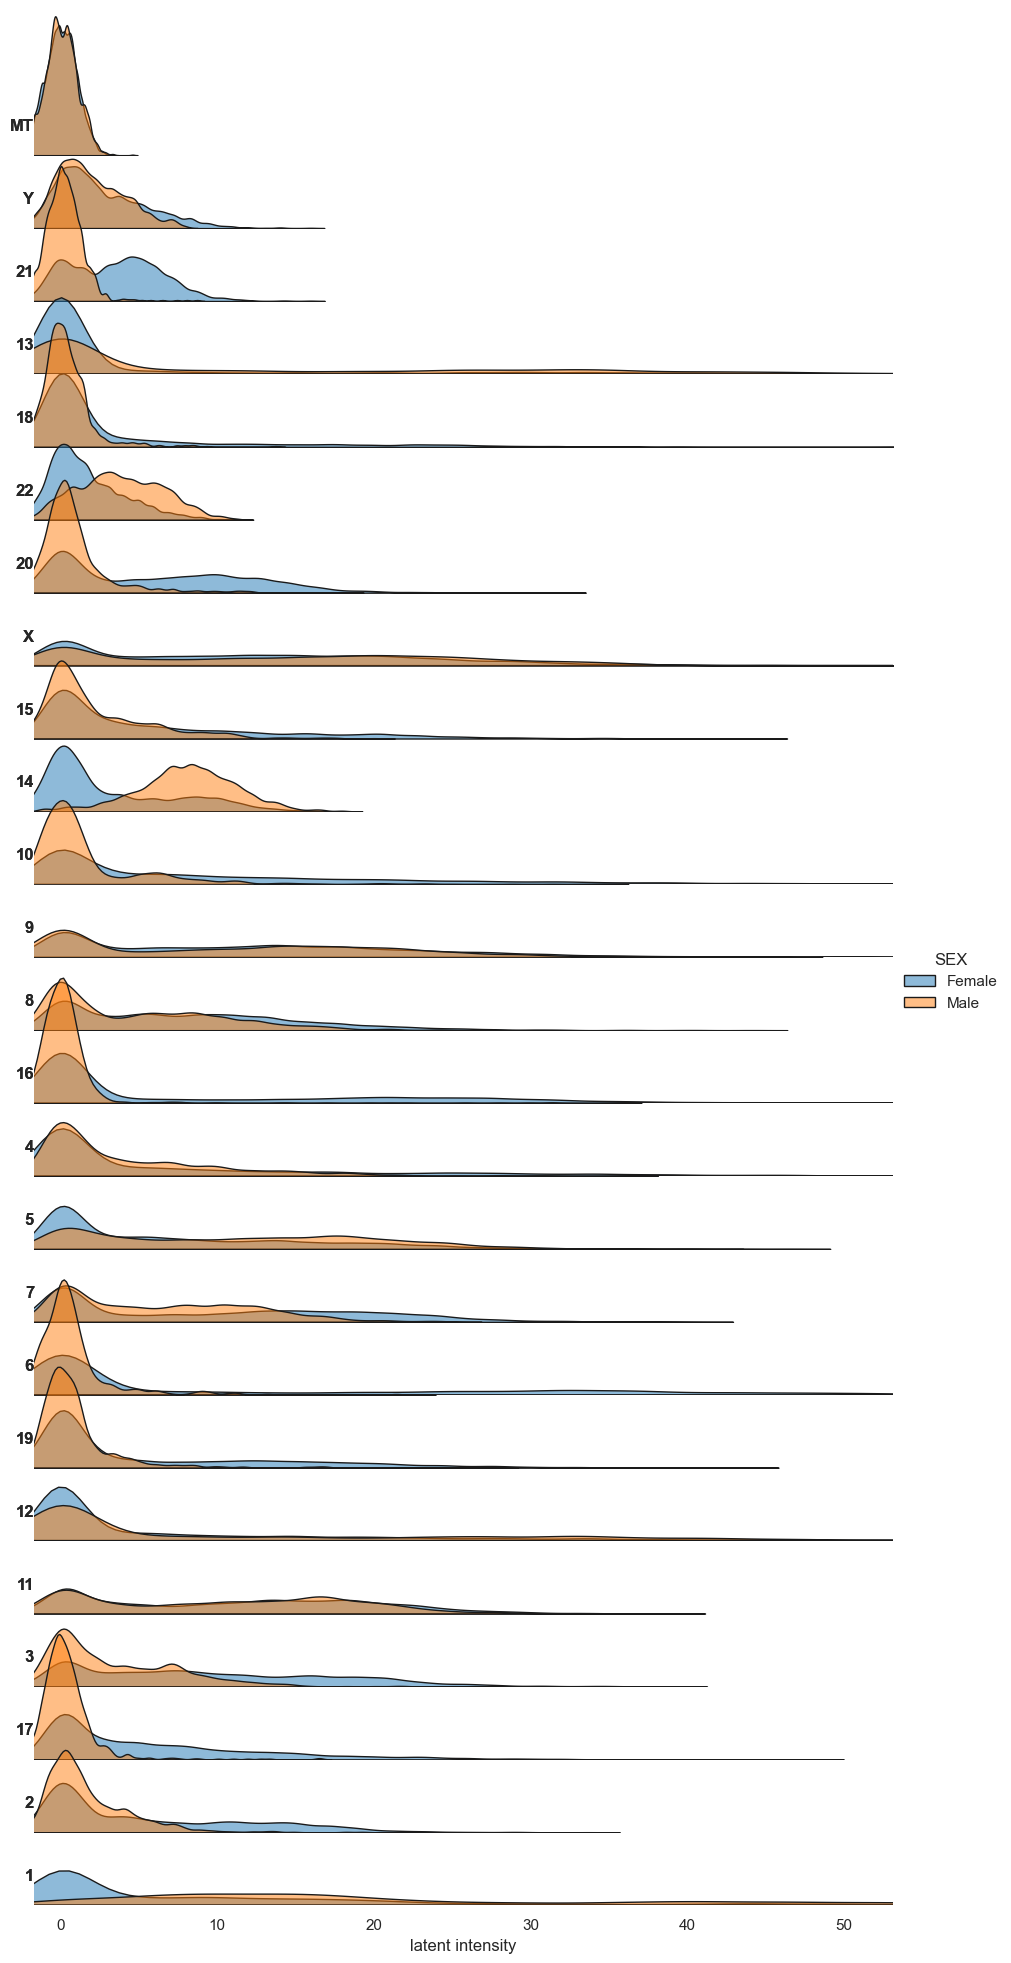

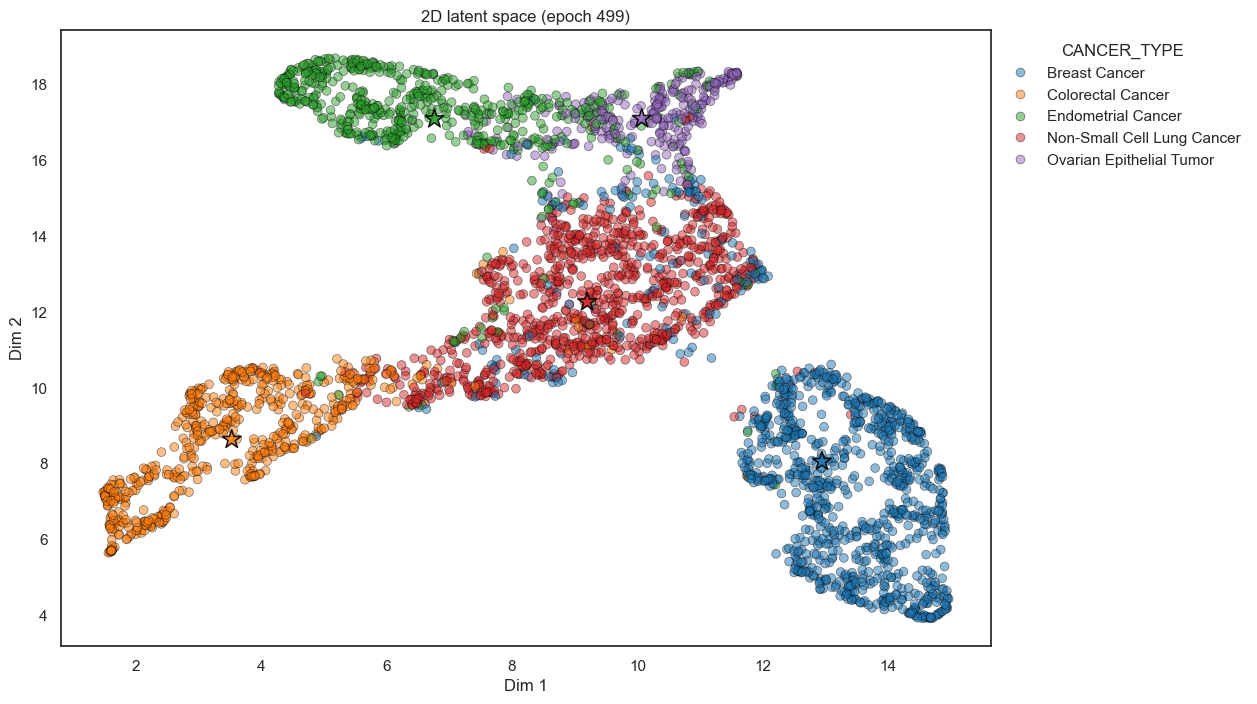

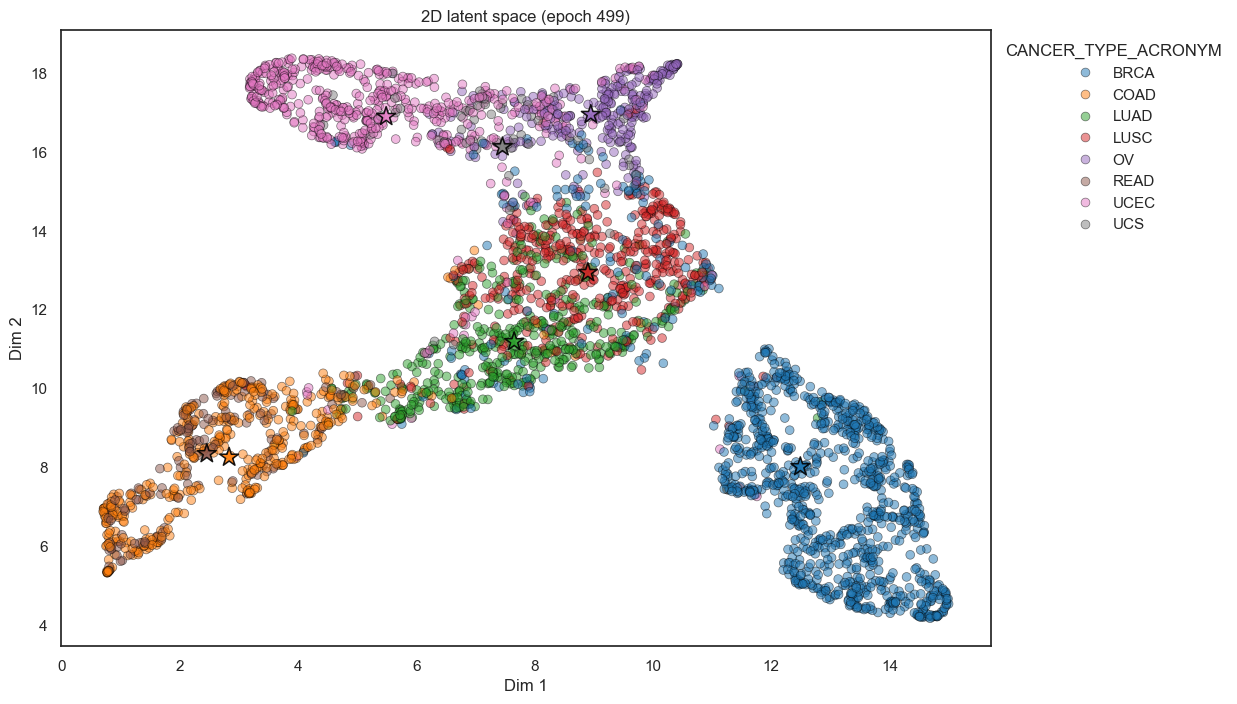

The provided label column is numeric and converted to categories.


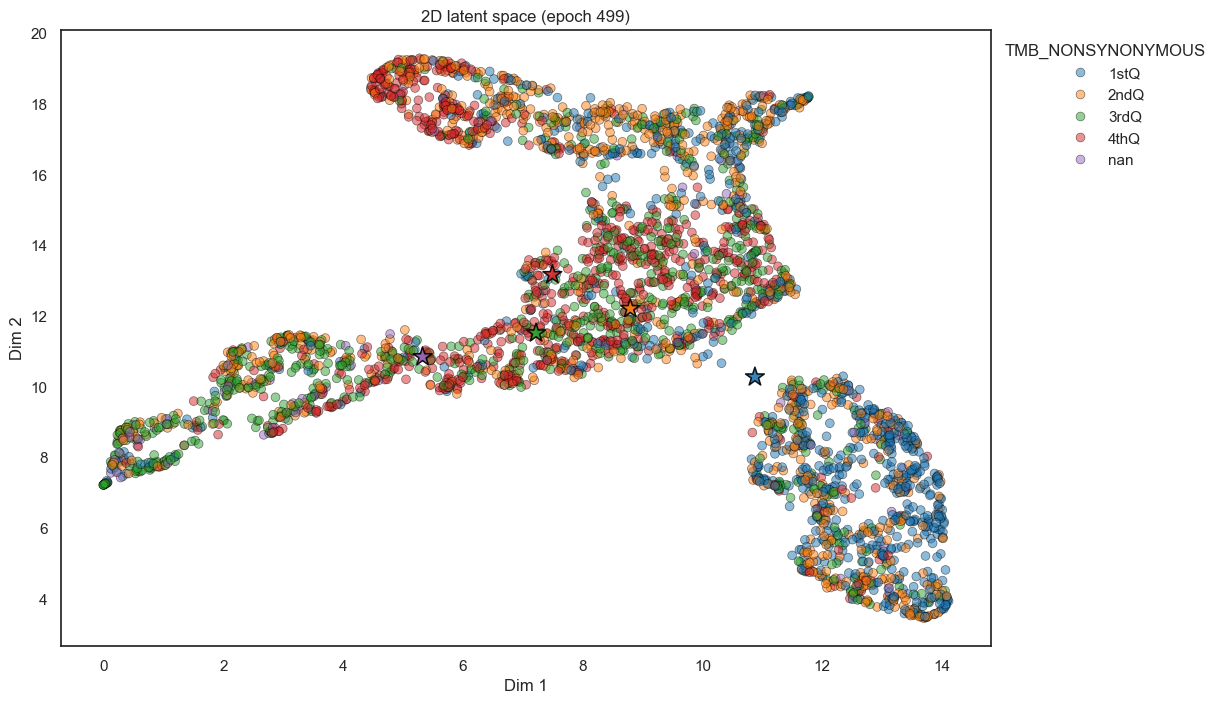

The provided label column is numeric and converted to categories.


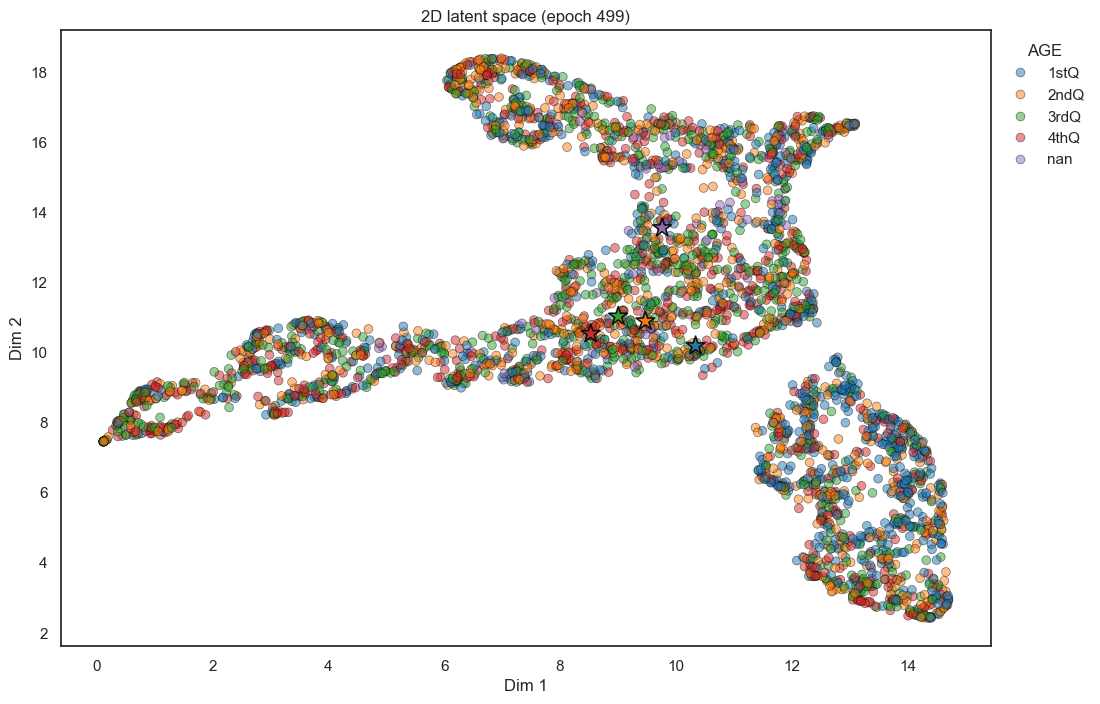

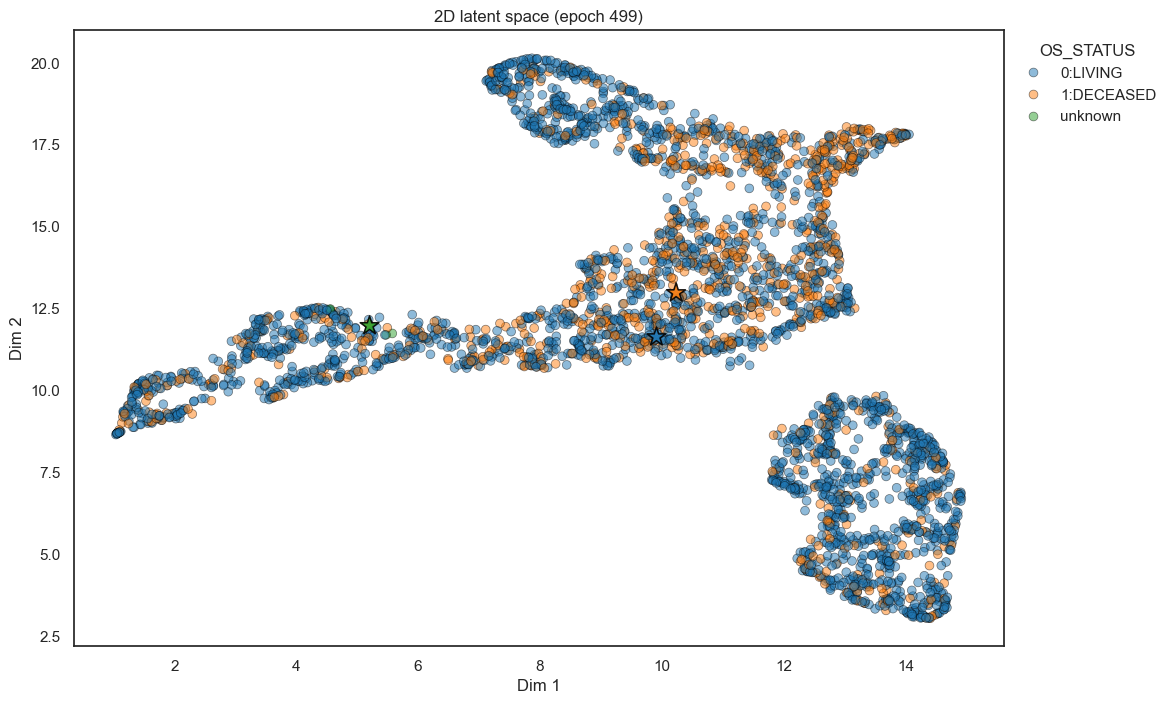

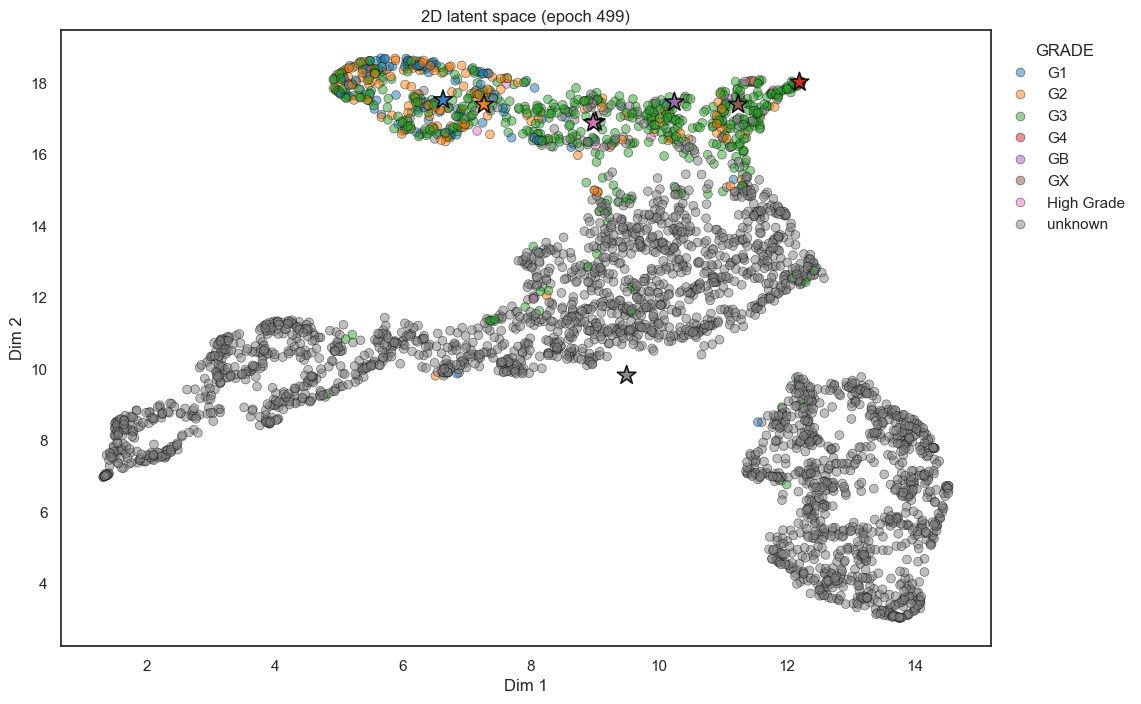

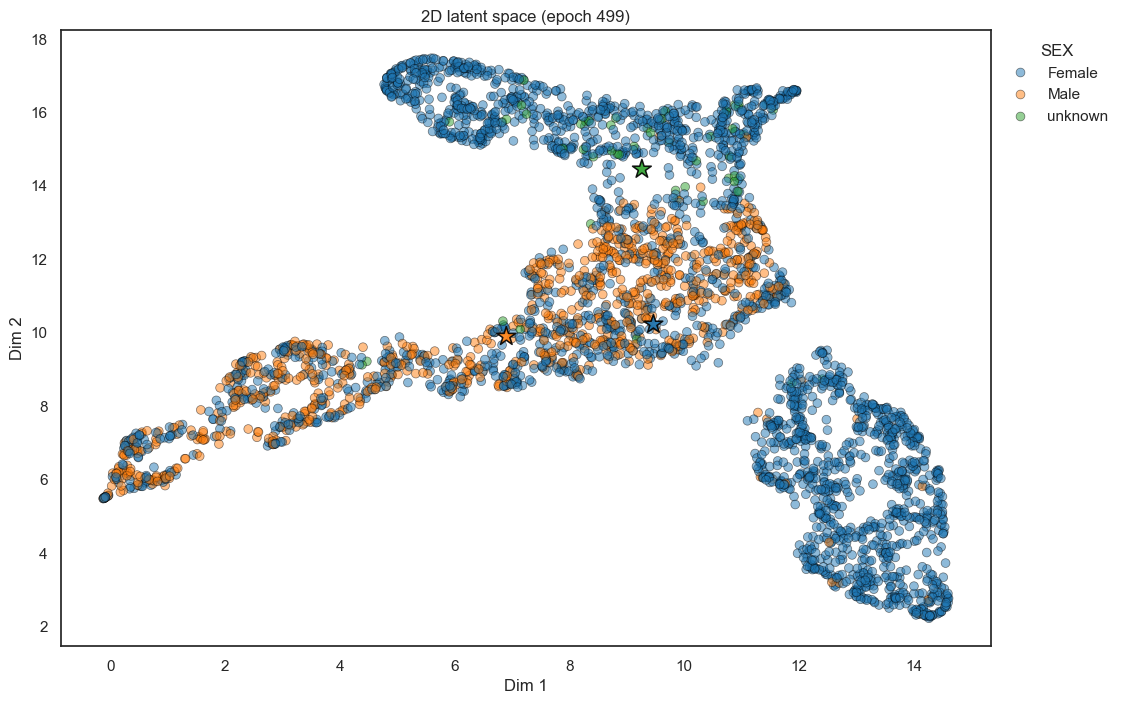

In [22]:


ontix.show_result()

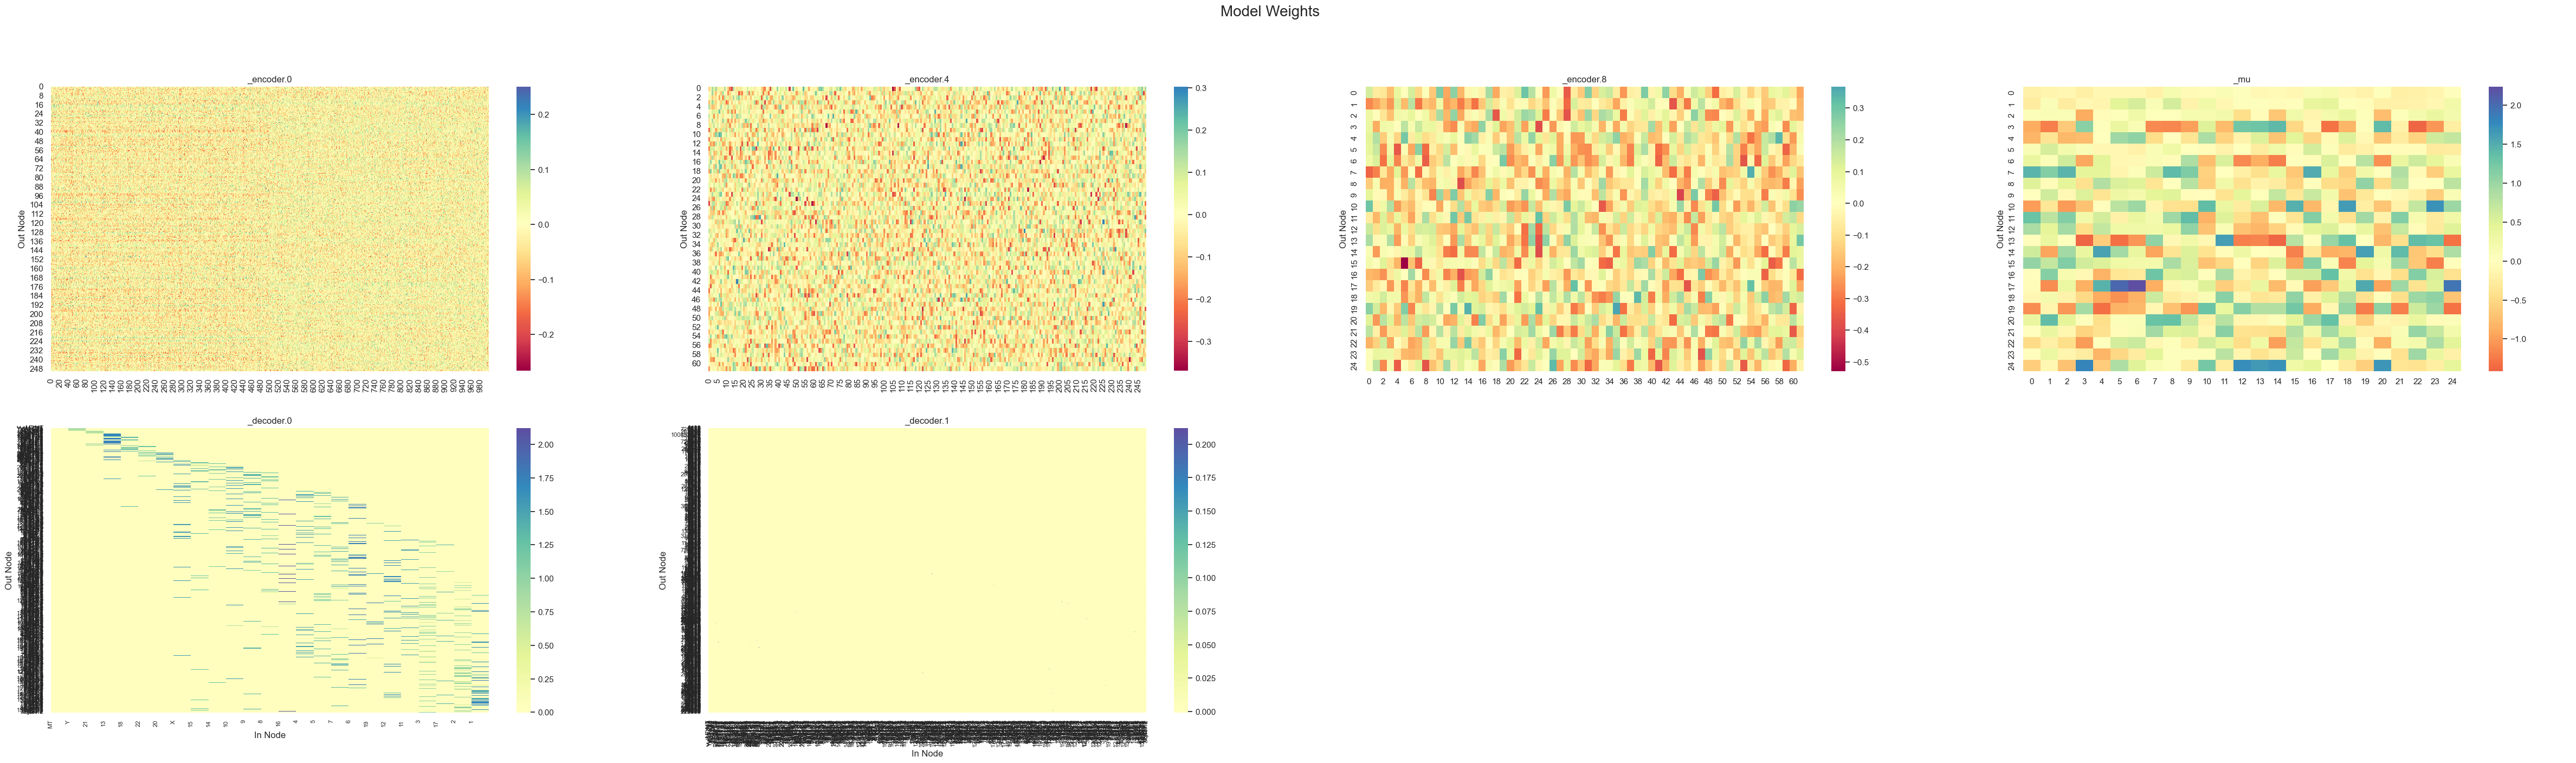

In [23]:
ontix.visualizer.show_weights()

## Reactome